In [2]:
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import backend
import os
import torch
import torch.utils.data
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from math import sin, cos
from PIL import ImageDraw, Image
import cv2
sys.path.append(os.path.abspath("./Residual-Attention-Network/"))

import cv2
import time

Using TensorFlow backend.


In [1]:
import json
from mpl_toolkits.mplot3d import Axes3D
import glob
car_model_file = []
for file in glob.glob("./car_models_json/*"):
    car_model_file.append(file)
car_dic = {}
for file in car_model_file:
    with open(file) as json_file:
        data = json.load(json_file)
        vertices = np.array(data['vertices'])
        triangles = np.array(data['faces']) - 1
        # plt.figure(figsize=(20,10))
        # ax = plt.axes(projection='3d')
        # ax.set_title('car_type: '+data['car_type'])
        # ax.set_xlim([-3, 3])
        # ax.set_ylim([-3, 3])
        # ax.set_zlim([0, 3])
        # ax.plot_trisurf(vertices[:,0], vertices[:,2], triangles, -vertices[:,1], shade=True, color='grey')
        width_pix = vertices[:,0]
        width_min = min(width_pix)
        width_max = max(width_pix)
        width = width_max - width_min
        height_pix = vertices[:,1]
        height_min = min(height_pix)
        height_max = max(height_pix)
        height = height_max - height_min
        length_pix = vertices[:,2]
        length_min = min(length_pix)
        length_max = max(length_pix)
        length = length_max - length_min
        name = file.split('/')
        name = name[2].split('.')
        name = name[0]
        car_dic[name] = [width, height, length]

In [3]:
train = pd.read_csv('./train.csv')
# k is camera instrinsic matrix
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype = np.float32)

In [4]:
# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

In [5]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[4][:2]), color, 16)

    cv2.line(image, tuple(points[1][:2]), tuple(points[5][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[6][:2]), color, 16)
    cv2.line(image, tuple(points[3][:2]), tuple(points[4][:2]), color, 16)
    cv2.line(image, tuple(points[3][:2]), tuple(points[7][:2]), color, 16)

    cv2.line(image, tuple(points[4][:2]), tuple(points[8][:2]), color, 16)
    cv2.line(image, tuple(points[5][:2]), tuple(points[8][:2]), color, 16)

    cv2.line(image, tuple(points[5][:2]), tuple(points[6][:2]), color, 16)
    cv2.line(image, tuple(points[6][:2]), tuple(points[7][:2]), color, 16)
    cv2.line(image, tuple(points[7][:2]), tuple(points[8][:2]), color, 16)
    return image


def draw_points(image, points):
    image = np.array(image)
    for (p_x, p_y) in points:
        # print("p_x, p_y", p_x, p_y)
        cv2.circle(image, (p_x, p_y), 5, (255, 0, 0), -1)
    return image

In [6]:
# image coordinate to world coordinate
def img_cor_2_world_cor():
    x_img, y_img, z_img = img_cor_points[0]
    xc, yc, zc = x_img*z_img, y_img*z_img, z_img
    p_cam = np.array([xc, yc, zc])
    xw, yw, zw = np.dot(np.linalg.inv(k), p_cam)
    print(xw, yw, zw)
    print(x, y, z)

In [7]:
# Now begin the initialization of dictionary for image training set
print(car_dic)

{'yingfeinidi-qx80': [2.28210571, 1.8278258499999998, 5.037961729999999], 'dongfeng-fengguang-S560': [1.86531914, 1.7434286300000001, 4.53487168], 'dongfeng-yulong-naruijie': [2.26946686, 1.75297043, 4.81037018], 'baoshijie-kayan': [2.2738341500000003, 1.8243073300000001, 5.34521392], 'bieke-kaiyue': [2.01257347, 1.45907648, 4.509908759999999], 'aodi-Q7-SUV': [2.25270828, 1.76139832, 5.05412979], 'oubao': [2.0877465799999997, 1.4733095600000001, 4.8313031], 'Skoda_Fabia-2011': [1.8595697000000002, 1.57594444, 3.99363403], 'dazhongmaiteng': [1.9739563700000002, 1.4896684399999998, 4.83009344], 'dongfeng-fengxing-SX6': [2.0925881200000003, 1.81654469, 4.60505661], 'sikeda-jingrui': [1.8811526500000002, 1.45154316, 3.9368396000000003], 'dazhong-SUV': [2.25716049, 1.73801133, 4.69595337], 'dongfeng-xuetielong-C6': [2.02599449, 1.4570455199999999, 4.82244445], 'MG-GT-2015': [2.05892639, 1.4970837399999999, 4.54781631], 'lingmu-swift': [1.91016708, 1.5212088799999999, 3.7692910800000003], 'x

In [7]:
X_MAX = 3383
Y_MAX = 2709
class stage2Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode = 'train'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train = pd.read_csv(csv_file)
        if mode == 'train':
            self.train = self.train[:int(self.train.shape[0]*0.7)]
        else:
            self.train = self.train[int(self.train.shape[0]*0.7):]
    def __len__(self):
        return self.train.shape[0]

    def __getitem__(self, idx):
        x_l = 1.02 # augment this
        y_l = 0.80 # augment this
        z_l = 2.31 # augment this
        # also do data augmentation later
        # try directly training on quaternion?
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = train.loc[idx]['ImageId']
        pred_string = train.loc[idx]['PredictionString']
        img = plt.imread('./train_images/' + img_name + '.jpg').astype(float)/255
        mg_y, mg_x = np.meshgrid(np.linspace(0, 1, img.shape[0]), np.linspace(0, 1, img.shape[1]), indexing = 'ij')
        #process prediction string
        items = pred_string.split(' ')
        model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]
        sample = []
        #iterate over each vehcicle
        for yaw, pitch, roll, x, y, z in zip(yaws, pitches, rolls, xs, ys, zs):
            yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
            img_x, img_y, img_z = np.dot(k, [x, y, z])
            #target = np.array([yaw, np.sin(pitch), np.cos(pitch), rotate(roll, np.pi), img_x/10000, img_y/10000, img_z/10]) #result to regress to
            target = np.array([yaw, np.sin(pitch), np.cos(pitch), rotate(roll, np.pi), x/5, y/5, z/5]) #result to regress to
            # I think the pitch and yaw should be exchanged
            yaw, pitch, roll = -pitch, -yaw, -roll
            Rt = np.eye(4)
            t = np.array([x, y, z])
            Rt[:3, 3] = t
            Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
            Rt = Rt[:3, :]
            P = np.array([[0, 0, 0, 1],
                          [x_l, y_l, -z_l, 1],
                          [x_l, y_l, z_l, 1],
                          [-x_l, y_l, z_l, 1],
                          [-x_l, y_l, -z_l, 1],
                          [x_l, -y_l, -z_l, 1],
                          [x_l, -y_l, z_l, 1],
                          [-x_l, -y_l, z_l, 1],
                          [-x_l, -y_l, -z_l, 1]]).T

            # call this function before change the astype
            img_cor_points = np.dot(k, np.dot(Rt, P)) # calculate 8 corners and center in terms of camera coordinate
            img_cor_points = img_cor_points.T
            img_cor_points[:, 0] /= img_cor_points[:, 2] # project onto 2d camera plane
            img_cor_points[:, 1] /= img_cor_points[:, 2]
            x_max = int(np.amax(img_cor_points[:,0])) # calculate 2d box
            if x_max>X_MAX:
                x_max = X_MAX
            x_min = int(np.amin(img_cor_points[:,0]))
            if x_min<0:
                x_min = 0
            y_max = int(np.amax(img_cor_points[:,1]))
            if y_max>Y_MAX:
                y_max = Y_MAX
            y_min = int(np.amin(img_cor_points[:,1])) 
            if y_min<0:
                y_min = 0
            # Crop image
            img_crop = cv2.resize(img[y_min:y_max, x_min:x_max], (224, 224))
            mg_x_crop = cv2.resize(mg_x[y_min:y_max, x_min:x_max], (224, 224))[..., np.newaxis]
            mg_y_crop = cv2.resize(mg_y[y_min:y_max, x_min:x_max], (224, 224))[..., np.newaxis]
            input_tensor = np.concatenate((img_crop, mg_y_crop, mg_x_crop), axis = 2).transpose((2, 0, 1))
            sample.append((input_tensor, target))
        return sample, img

In [8]:
stage2set = stage2Dataset('./train.csv')
trainloader = torch.utils.data.DataLoader(stage2set, batch_size=1, shuffle = True)

In [37]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np
from model.basic_layers import ResidualBlock
from model.attention_module import AttentionModule_stage1, AttentionModule_stage2, AttentionModule_stage3, AttentionModule_stage0
from model.attention_module import AttentionModule_stage1_cifar, AttentionModule_stage2_cifar, AttentionModule_stage3_cifar
class ResidualAttentionModel_56(nn.Module):
    # for input size 224
    def __init__(self):
        super(ResidualAttentionModel_56, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual_block1 = ResidualBlock(64, 256)
        self.attention_module1 = AttentionModule_stage1(256, 256)
        self.residual_block2 = ResidualBlock(256, 512, 2)
        self.attention_module2 = AttentionModule_stage2(512, 512)
        self.residual_block3 = ResidualBlock(512, 1024, 2)
        self.attention_module3 = AttentionModule_stage3(1024, 1024)
        self.residual_block4 = ResidualBlock(1024, 2048, 2)
        self.residual_block5 = ResidualBlock(2048, 2048)
        self.residual_block6 = ResidualBlock(2048, 2048)
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(2048,7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.mpool1(out)
        # print(out.data)
        out = self.residual_block1(out)
        out = self.attention_module1(out)
        out = self.residual_block2(out)
        out = self.attention_module2(out)
        out = self.residual_block3(out)
        # print(out.data)
        out = self.attention_module3(out)
        out = self.residual_block4(out)
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        out = self.mpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [48]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)    # 224x224
        x = self.bn1(x)     
        x = self.relu(x)
        x = self.maxpool(x)  # 112x112

        x = self.layer1(x)   # 56x56
        x = self.layer2(x)   # 28x28
        x = self.layer3(x)   # 14x14
        x = self.layer4(x)   # 7x7

        x = self.avgpool(x)  # 1x1
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [51]:
from torchvision.models import resnet18
net.add_module('conv1', torch.nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
net.add_module('fc', torch.nn.Linear(in_features=512, out_features=7, bias=True))
net = ResidualAttentionModel_56() #this is the attention version, which is much slower
net = ResNet(BasicBlock, [2, 2, 2, 2])
net.train()
for parameter in net.parameters():
    if len(parameter.shape)>1:
        torch.nn.init.xavier_uniform_(parameter, gain=1.0)

In [52]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
for batch_idx, (sample, img) in enumerate(trainloader):
    X = torch.zeros([len(sample), 5, 224, 224])
    Y = torch.zeros([len(sample), 7])
    for sample_idx, (input_tensor, target) in enumerate(sample):
        X[sample_idx] = input_tensor[0]
        Y[sample_idx] = target[0]
    optimizer.zero_grad()
    begin = time.time()
    outputs = net(X)
    #print(outputs.shape)
    angleloss = criterion(outputs[:, :4], Y[:, :4])
    xyzloss = criterion(outputs[:, 4:], Y[:, 4:])
    loss = xyzloss
    loss.backward()
    optimizer.step()
    #print(time.time()-begin)
    print(angleloss.detach().numpy(), xyzloss.detach().numpy())
    #pred_xyz = torch.Tensor(np.dot(np.linalg.inv(k), (outputs[:, 4:].detach().numpy()*[10000, 10000, 10]).T).T/5)
    #true_xyz = torch.Tensor(np.dot(np.linalg.inv(k), (Y[:, 4:].detach().numpy()*[10000, 10000, 10]).T).T/5)
    #print('metric loss is ', criterion(pred_xyz, true_xyz).detach().numpy())
    torch.save(net.state_dict(), './weights/resnet18.pt')

0.614623 47.490387
1.0644507 35.088417
1.1028321 22.927244
0.90898097 31.48851
0.9139953 9.990506
1.0049194 11.935457
0.9397225 46.475597
1.0072045 26.86759
0.969556 6.599422
0.75233936 28.800488
0.95211387 50.245605
0.9736958 38.03584
1.5887895 14.733337
1.3613126 36.69125
0.91583735 9.804962
1.4019518 4.6333838
1.1007311 28.15761
1.3017333 11.878866
1.4095986 13.732741
1.4210136 7.559166
0.972391 24.332487
0.9576096 3.694537
1.4802161 11.532097
1.2420365 19.638641
1.0362803 10.527145
1.0327463 7.5821767
1.5533739 8.604129
1.3685398 9.46486
1.2038156 8.002281
0.7341531 15.684692
1.467994 6.783596
1.0477517 6.4020796
0.9831729 2.6494458
1.2241365 7.6473513
1.1358464 10.305142
1.2501107 8.9962635
1.5693376 15.542166
1.7739452 9.890388
1.3268808 24.086407
1.1823208 6.2123837
1.1879923 9.183809
1.6946434 9.43048
1.4699017 4.74182
1.5066142 5.596021
1.1173394 21.485804
1.2381585 12.349428
0.90265346 9.732862
1.1087419 3.5460763
1.006497 7.912479
1.1172985 8.6207485
1.2971826 14.519873
1.40

KeyboardInterrupt: 

(10, 2)


W0111 13:49:32.163310 139871109109568 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


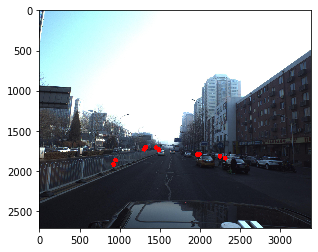

In [31]:
#visualize
pred_xyz = outputs[:, 4:].detach().numpy()*100
camera_xyz = np.dot(k, pred_xyz.T).T
camera_xyz[:, 0]/=camera_xyz[:, 2]
camera_xyz[:, 1]/=camera_xyz[:, 2]
img_xyz = camera_xyz[:, :2]
print(img_xyz.shape)
image = np.array(img[0])
for [p_x, p_y] in img_xyz:
    cv2.circle(image, (p_x, p_y), 30, (255, 0, 0), -1)
plt.imshow(image)